#All imports

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Loading data

In [22]:
airbnb_raw=pd.read_csv('/workspaces/machine-learning-python/data/raw/airbnb.csv')

**Data Description:**

**variable name |	Description**
--- | ---
id |	listing ID
name	| name of the listing
host_id	| host ID
host_name	| name of the host
neighbourhood_group | 	location
neighbourhood	| area
latitude	| latitude coordinates
longitude	| longitude coordinates
room_type | listing space type
price	| price in dollars
minimum_nights| 	amount of minimum nights to book
number_of_reviews	| number of reviews
last_review	| date of latest review
reviews_per_month | 	number of reviews per month
calculated_host_listings_count| 	amount of listing per host
availability_365	| number of days when listing is available for booking



#Data Exploration & cleaning

Getting details about data:
*    16 variables 48,895  observations
*    last_review &  reviews_per_month have the most missing data

In [23]:
airbnb_raw.info()
airbnb_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Checking for duplicates:
*    No duplicated data:




In [24]:
print(airbnb_raw.duplicated('id').sum())
print(airbnb_raw.duplicated().sum())

0
0


Duplicated data at the host_id level is expected as one host can own several listings:

In [25]:
print('Host ID duplicated observations: '+ str(airbnb_raw.duplicated('host_id').sum()))
print('Total listings per host duplicated observations: '+ str(airbnb_raw.duplicated(['host_id','calculated_host_listings_count']).sum()))

Host ID duplicated observations: 11438
Total listings per host duplicated observations: 11438


Deleting irrelevant variables:
*    name
*    host_name: This is a more sensitive information that needs to be deleted as soon as the data is loaded as it contains personal information. In this case, this variable only contains the first name of the host, therefore it may not be a major problem in this case. However, in some instances data may contain information identifying people and it should be removed. Best practice is to anonimise data.



In [26]:
airbnb_raw.drop(['name', 'host_name'], axis=1, inplace=True)

#Graphical Analysis

##Missing data distribution:

*    last_review & reviews_per_month have the most missing data:

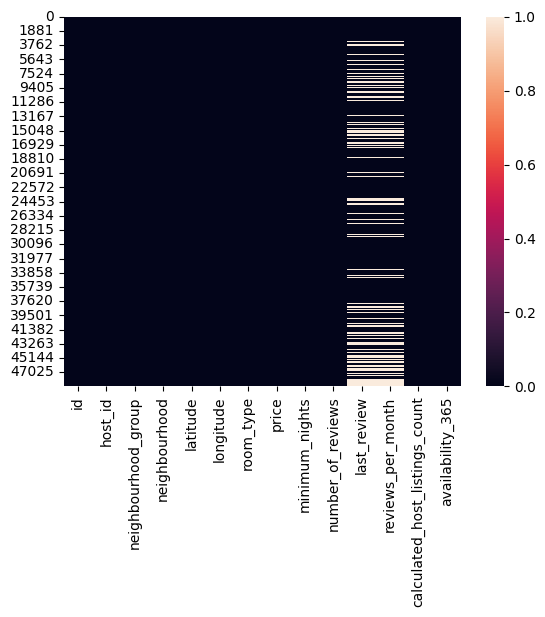

In [27]:
sns.heatmap(airbnb_raw.isnull())
plt.show()

In [28]:
airbnb_raw.isnull().sum().sort_values(ascending=False)

last_review                       10052
reviews_per_month                 10052
id                                    0
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

##Univariate analysis

###Summary stats

*   Average price per night 152 USD, further exploration needed as some prices are listed at 0 USD (check minimum). Almost unlikely to find a listing in NYC for 0 USD!
*   On average rentals require to book a minimum of 7 nights. Further exploration needed as there may be some outliers. There is a listing with a maximum value of 1200 nights
*   Hosts on average own 7 listins
*   On average, listins are available 112 days per year

In [29]:
airbnb_raw.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


*   There are 5 neighbourhood groups and a total of 221 neighbourhoods
*   There are 3 different types of rooms rented



In [30]:
airbnb_raw.describe(include='O')

,neighbourhood_group,neighbourhood,room_type,last_review
count,48895,48895,48895,38843
unique,5,221,3,1764
top,Manhattan,Williamsburg,Entire home/apt,2019-06-23
freq,21661,3920,25409,1413


###**Graphs**

What do the histograms say?
*    Most airbnb rentals in NYC rent a private room or entire flat/home
*    Most places charge less than 500 USD per night
*    Most rentals have in total less than 50 reviews
*    Most rentals receive less than 5 reviews per month
*    The majority of rentals are located in Brooklyn and Manhattan
*    The numbers of days available in most listings varies and most of them are not available the whole year. The latter means there may be some seasonal trends, meaning that hosts probably decide to rent their properties during specific times of the year


/tmp/ipykernel_2276/3085850355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[0,0].set_xticklabels(axis[0,0].get_xticklabels(), rotation=45)
/tmp/ipykernel_2276/3085850355.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[2,0].set_xticklabels(axis[2,0].get_xticklabels(), rotation=45)


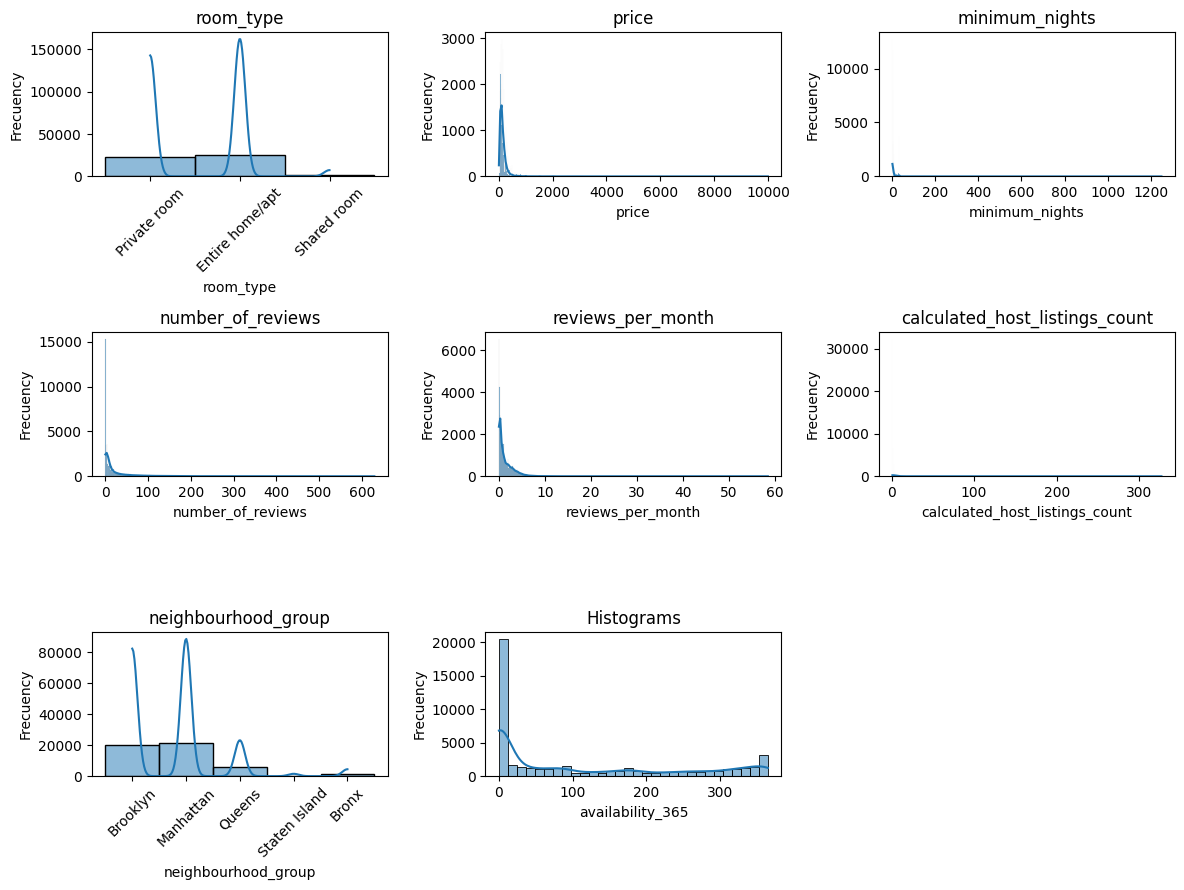

In [31]:
varlist=['room_type', 'price','minimum_nights', 'number_of_reviews','reviews_per_month', 'calculated_host_listings_count','neighbourhood_group','availability_365']
cols=3
rows=((len(varlist) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(varlist, axis.flatten()):
  sns.histplot(airbnb_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('Frecuency')

axis[0,0].set_xticklabels(axis[0,0].get_xticklabels(), rotation=45)
axis[2,0].set_xticklabels(axis[2,0].get_xticklabels(), rotation=45)
#removing empty subplots
for i in range(len(varlist), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.title('Histograms')
plt.tight_layout()
plt.show()

**Further exploration for outliers:**



*   There are some outlier listings when it comes to price as some cost more than 2,000 USD per night. However, this result is not a surprise as NYC is one of the most expensive cities according to the World Economic Forum.
*   The minimum number of nights has outliers as well. Roughly 5 listings require a minimum of 600 nights or more to be booked. It is not clear if this issue is a data-input mistake or if there are some long-term listings on airbnb. Using the interquantile range, there are more than 6,000 listings classified as outliers, requiring a minimum of more than 11 nights to book the home/flat/room.
*   There are some listings (roughly 3,000 listings) with more than 100 reviews when the average is 23. A similar case occurs with the number of reviews per month
*   Thera are also roughtly 7,000 outlying rentals (using the interquantile method) from hosts who accumulate several listings. Although, to some extent, this result is expected as there is a big real state industry around airbnb in New York; according to The New York Times and The Guardian, the city is facing a major residential crisis.   

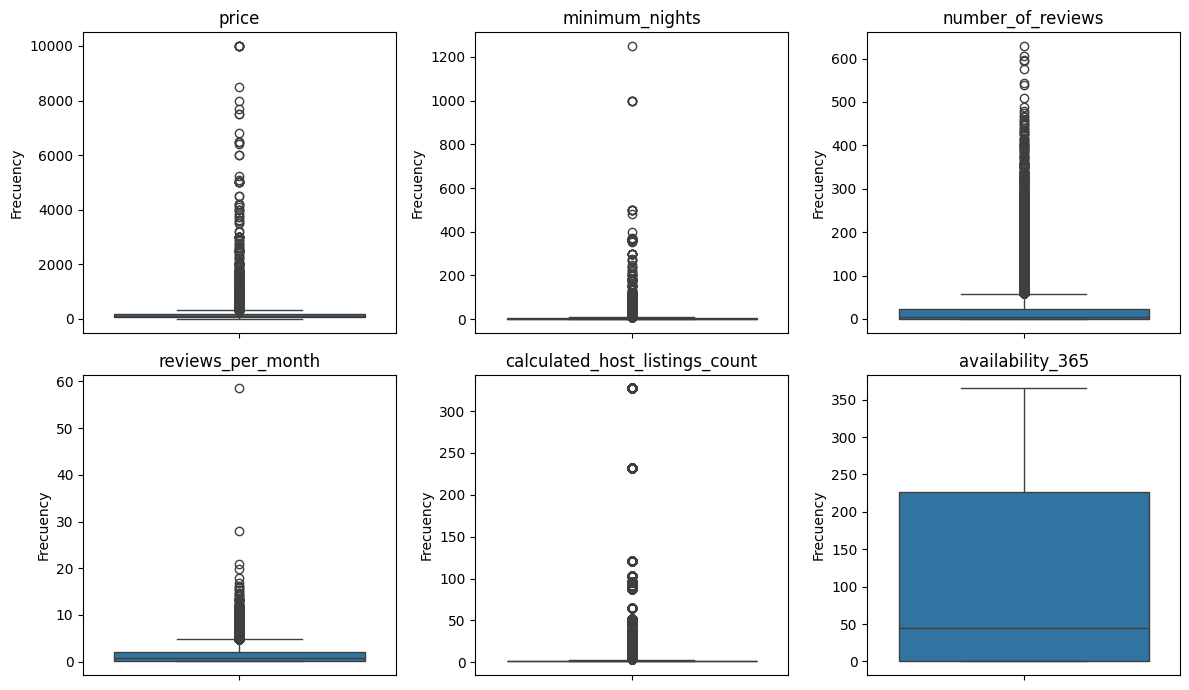

In [32]:
varlist=['price','minimum_nights', 'number_of_reviews','reviews_per_month', 'calculated_host_listings_count','availability_365']
cols=3
rows=((len(varlist) - 1) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3.5))

for col, ax in zip(varlist, axis.flatten()):
  sns.boxplot(airbnb_raw[col], ax=ax)
  ax.set_title(col)
  ax.set_ylabel('Frecuency')


#removing empty subplots
for i in range(len(varlist), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

#plt.title('Histograms')
plt.tight_layout()
plt.show()

**Checking some descriptive stats for outliers:**

Minimum nights:

In [33]:
airbnb_raw[['minimum_nights']][airbnb_raw['minimum_nights']>600].describe()

,minimum_nights
count,5.000000
mean,1049.400000
std,112.139645
min,999.000000
25%,999.000000
50%,999.000000
75%,1000.000000
max,1250.000000


In [34]:
#Interquartile range method to detect outlies
Q1 = airbnb_raw['minimum_nights'].quantile(0.25)
Q3 = airbnb_raw['minimum_nights'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(upper_bound)
print(airbnb_raw[['minimum_nights']][airbnb_raw['minimum_nights']>upper_bound].describe())


11.0
       minimum_nights
count     6607.000000
mean        34.715907
std         46.959229
min         12.000000
25%         28.000000
50%         30.000000
75%         30.000000
max       1250.000000


Number of reviews:

In [35]:
airbnb_raw[['number_of_reviews']][airbnb_raw['number_of_reviews']>100].describe()

,number_of_reviews
count,2995.000000
mean,164.369950
std,65.409353
min,101.000000
25%,119.000000
50%,144.000000
75%,190.000000
max,629.000000


Count of listings per host:

In [36]:
#Interquartile range method to detect outlies
Q1 = airbnb_raw['calculated_host_listings_count'].quantile(0.25)
Q3 = airbnb_raw['calculated_host_listings_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(upper_bound)
print(airbnb_raw[['calculated_host_listings_count']][airbnb_raw['calculated_host_listings_count']>upper_bound].describe())


3.5
       calculated_host_listings_count
count                     7081.000000
mean                        41.678718
std                         78.115838
min                          4.000000
25%                          5.000000
50%                          8.000000
75%                         33.000000
max                        327.000000


##Multivariate analysis

###Multicollinearity assessment

*    There are no major correlations among most variables
*    There is some correlation between reviews per month and number of reviews, which is expected since they are collinear by definition

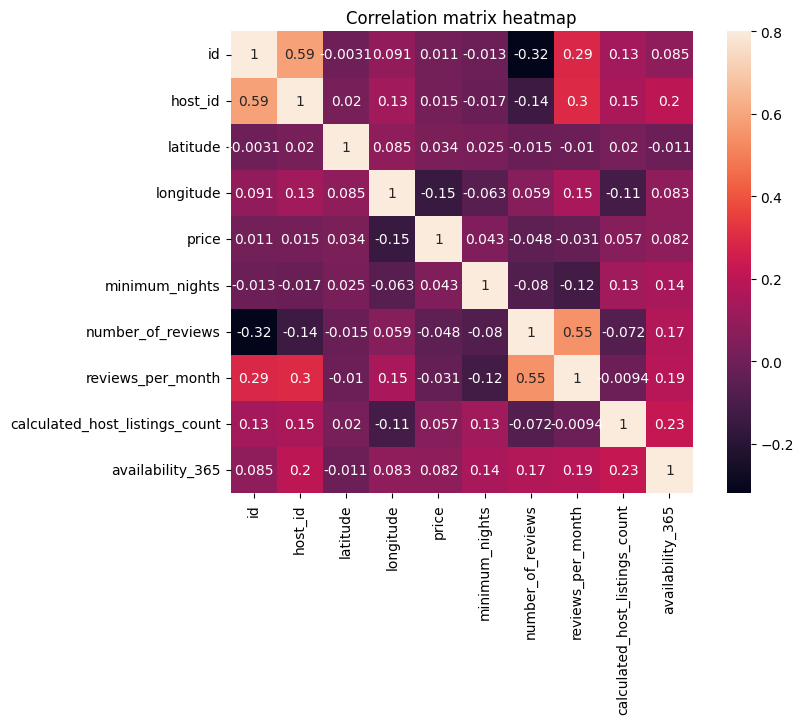

In [37]:
corr = airbnb_raw.select_dtypes(include=['number']).corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, vmax=.8, square=True, annot=True)
plt.title('Correlation matrix heatmap')
plt.show()

In [38]:
airbnb_raw.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

**Descriptive relationship of variables:**
*   According to the pairplot, it seems that the variable minimum_nights drives several of the outliers when analysing its relationship with the rest of the dataframe variables
*   The same case occurs when looking at the relationship between reviews per month and the rest of the variables. The scatter plots show outlier dots for reviews per month = 60
*   When looking at the relationship between the number of listings per host and the rest of the variables, most of the relationships seem to occur for less than 200 listings per host.
*    Several of the relationships seem, descriptively, to follow a reciprocal function. For example, when looking at the relationship of price and number of reviews, the tails of the graph. Meaning that the higher the number of reviews the lower is the price of the listing. One possible hypothesis could be that cheaper listings may be lower quality and people may be more keen to leave reviews in lower-quality-cheap listings.


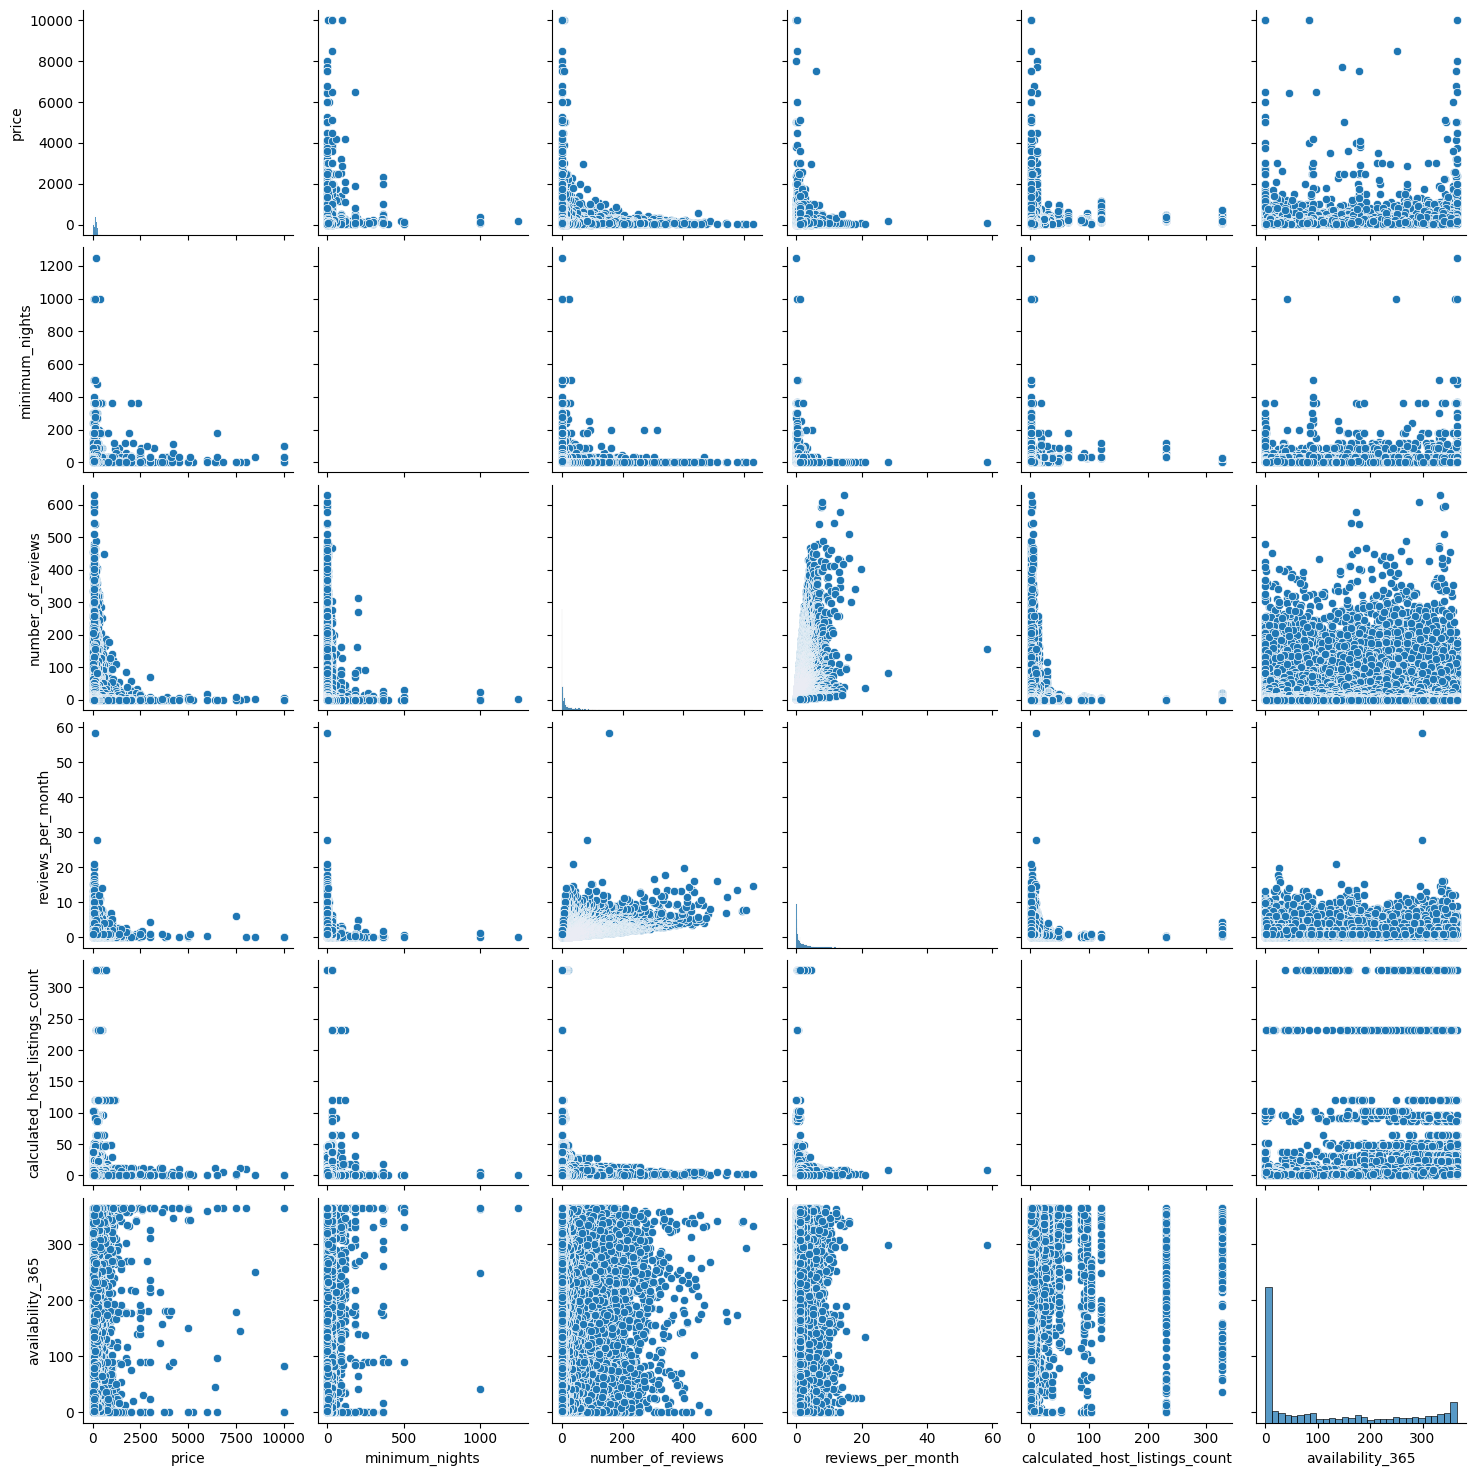

In [39]:
list2=['neighbourhood_group','room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
sns.pairplot(airbnb_raw[list2], corner=False)
plt.show()

###Cross tabulation analysis of variables

**Price vs Neighbourhood and room type:**

*    Airbnb rentals are on average more expensive in the areas of Brooklyn and Manhattan
*    Entire homes/flats are on average the most expensive

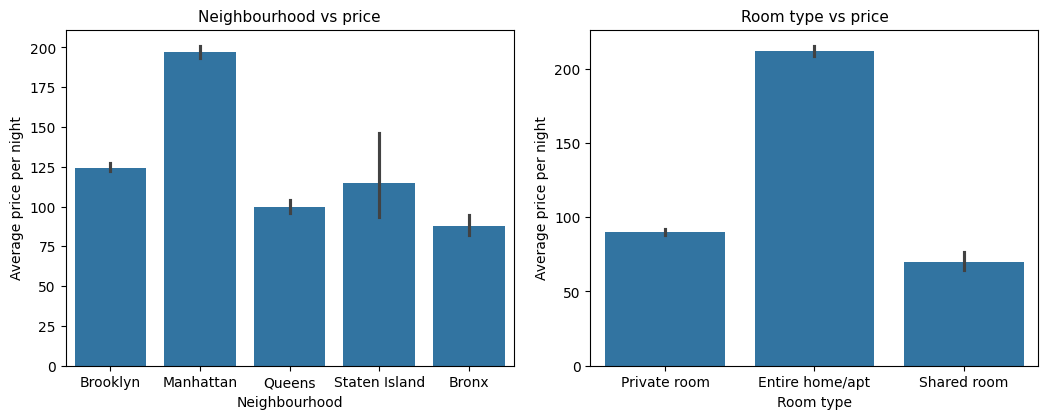

In [40]:
fig=plt.figure()
fig1=fig.add_axes([0.1,0.1,0.7,0.7])
fig2=fig.add_axes([0.92,0.1,0.7,0.7]) #coodinates: [x, y,] size[width, height]
sns.barplot(data=airbnb_raw, x='neighbourhood_group', y='price', ax=fig1)
fig1.set_ylabel('Average price per night')
fig1.set_xlabel('Neighbourhood')
fig1.set_title('Neighbourhood vs price').set_fontsize(11)
sns.barplot(data=airbnb_raw, x='room_type', y='price', ax=fig2)
fig2.set_ylabel('Average price per night')
fig2.set_xlabel('Room type')
fig2.set_title('Room type vs price').set_fontsize(11)
plt.show()


**Total reviews vs Neighbourhood:**

*    Brooklyn and Manhattan on average have fewer reviews compared to the remaining areas. Shared rooms also have lower reviews on average

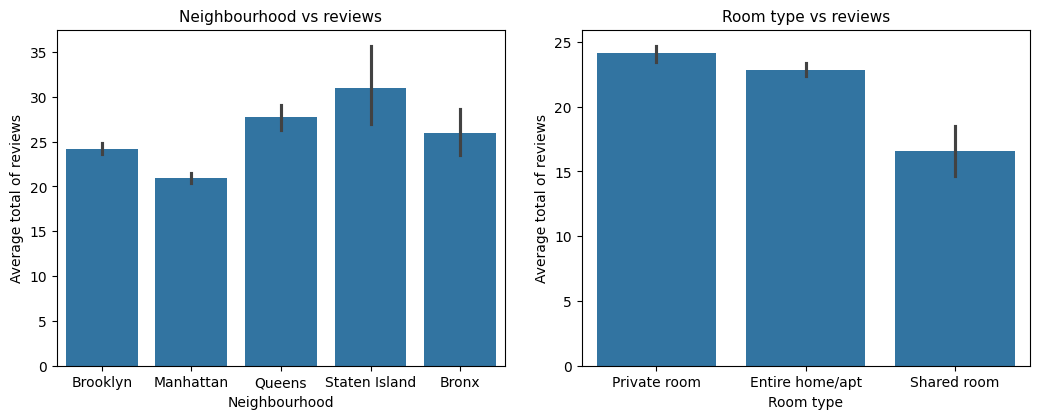

In [41]:
fig=plt.figure()
fig1=fig.add_axes([0.1,0.1,0.7,0.7])
fig2=fig.add_axes([0.92,0.1,0.7,0.7]) #coodinates: [x, y,] size[width, height]
sns.barplot(data=airbnb_raw, x='neighbourhood_group', y='number_of_reviews', ax=fig1)
fig1.set_ylabel('Average total of reviews')
fig1.set_xlabel('Neighbourhood')
fig1.set_title('Neighbourhood vs reviews').set_fontsize(11)
sns.barplot(data=airbnb_raw, x='room_type', y='number_of_reviews', ax=fig2)
fig2.set_ylabel('Average total of reviews')
fig2.set_xlabel('Room type')
fig2.set_title('Room type vs reviews').set_fontsize(11)
plt.show()


**Listings per host vs Price:**
*    NOTE:The barplot is updated by removing duplicates at the host_id level since one host can own several properties
*    The scatterplot suggests a non-linear negative relationship between the price of a listing and the number of properties owned by the host. meaning that hosts that own fewer properties seem to charge higher prices
*    The barplot suggests that on average one host owns more properties in the areas of Queens, Staten Island, and Bronx
*    From these graphs plus the graph showing average prices per neighbourhood we could argue that it is likely that in the areas of Brooklyn and Manhattan hosts own fewer properties and charge more per night.


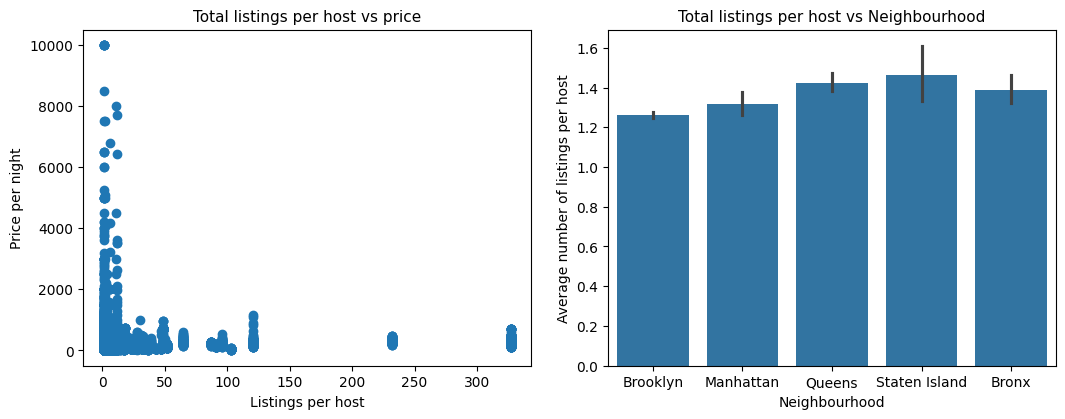

In [42]:
fig=plt.figure()
fig1=fig.add_axes([0.1,0.1,0.7,0.7])
fig2=fig.add_axes([0.92,0.1,0.7,0.7]) #coodinates: [x, y,] size[width, height]
fig1.scatter(data=airbnb_raw[['price','host_id', 'calculated_host_listings_count']], x='calculated_host_listings_count', y='price')
fig1.set_ylabel('Price per night')
fig1.set_xlabel('Listings per host')
fig1.set_title('Total listings per host vs price').set_fontsize(11)
sns.barplot(data=airbnb_raw[['neighbourhood_group','host_id', 'calculated_host_listings_count']].drop_duplicates('host_id'), x='neighbourhood_group', y='calculated_host_listings_count', ax=fig2)
fig2.set_ylabel('Average number of listings per host')
fig2.set_xlabel('Neighbourhood')
fig2.set_title('Total listings per host vs Neighbourhood').set_fontsize(11)
plt.show()


#Data Cleaning

Following the descriptive analysis performed above, the following changes will be conducted to clean the data:

*   Remove the variable **'neighbourhood'** and keep the variable 'neighbourhood_group' since the former one contains many categories which may be difficult to work with when creating the statistical model. 'neighbourhood_group' contains fewer categories, which are easier to incorporate in the model.

*    **'host_id'** will be kept. Although it **does not** add predictive power to the model, if the estimation is done at the host_id level, this variable will be necessary to transform the data

*   From the variable **'minimum_nights'** only the observations that are lower than 600 will be kept. Although the interquartile range method suggests that observations with more than 11 minimum nights are outliers, according to the pairplot, most of the interactions occur for rentals with less than 600 minimum nights. Datapoints above this value are the extreme values of this variable.

*    The variable of **'price'** will remain unchanged. Price is a key variable in an expensive and touristic place like New York City. Outliers in this context have a lot of power on defining short-term and long-term rentals as well as real state prices. Therefore, removing outliers on this variable could bias downards the estimates of the statistical model. Additionally, Airbnb also offers luxury rentals to target a different set of customers, hence, why some rentals look more expensive than the rest.

*    The variable **'last_review'** will be deleted as it only contains the date of the latest review and it will not add valuable information to the model.

*    The variables **number_of_reviews'** and **'reviews_per_month'** are correlated but, as shown below, reviews_per_month contains a lot of missing information. Therefore, only number_of_reviews will be kept

In [43]:
print(airbnb_raw[['number_of_reviews', 'reviews_per_month']].describe())

       number_of_reviews  reviews_per_month
count       48895.000000       38843.000000
mean           23.274466           1.373221
std            44.550582           1.680442
min             0.000000           0.010000
25%             1.000000           0.190000
50%             5.000000           0.720000
75%            24.000000           2.020000
max           629.000000          58.500000


*    Caution is necessary when addressing outliers of **'calculated_host_listings_count'** variable since NYC has a big real state and rental market. Hence, it is expected that one host owns several rentals and the interquartile method to detect outliers is not a useful criteria to decide which observations will be deleted since it does not capture the reality of the NYC market. According to the pairplots, the most extreme values of this variable are for more than 200 properties, which represents roughly 550 listings belonging to only 2 hosts(see stats below). These rows will be removed.

In [44]:
airbnb_raw[['calculated_host_listings_count']][airbnb_raw['calculated_host_listings_count']>200].describe().T

,count,mean,std,min,25%,50%,75%,max
calculated_host_listings_count,559.0,287.572451,46.850957,232.0,232.0,327.0,327.0,327.0


In [45]:
airbnb_raw[['calculated_host_listings_count', 'host_id']][airbnb_raw['calculated_host_listings_count']>200].drop_duplicates().groupby('host_id')['calculated_host_listings_count'].mean()


host_id
107434423    232.0
219517861    327.0
Name: calculated_host_listings_count, dtype: float64

**Final data:**

In [46]:
#removing irrelevant variables
airbnb_clean=airbnb_raw.copy()
airbnb_clean.drop(['neighbourhood','reviews_per_month' ,'last_review'], axis=1, inplace=True)

#removing extreme values
conditions=(airbnb_clean['minimum_nights']>600)|(airbnb_clean['calculated_host_listings_count']>200)
airbnb_clean.drop(airbnb_clean[conditions].index, inplace=True)

#Feature selection does not accept string variables
#Below is the transformation of neighbourhood group and room type from string to value label variable
label_encoder = LabelEncoder()
airbnb_clean['neighbourhood_group'] = label_encoder.fit_transform(airbnb_clean['neighbourhood_group'])
airbnb_clean['room_type'] = label_encoder.fit_transform(airbnb_clean['room_type'])

#Storing new data
airbnb_clean.to_csv("/workspaces/machine-learning-python/data/processed/airbnb_clean.csv", index=False)

In [47]:
airbnb_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48331 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48331 non-null  int64  
 1   host_id                         48331 non-null  int64  
 2   neighbourhood_group             48331 non-null  int64  
 3   latitude                        48331 non-null  float64
 4   longitude                       48331 non-null  float64
 5   room_type                       48331 non-null  int64  
 6   price                           48331 non-null  int64  
 7   minimum_nights                  48331 non-null  int64  
 8   number_of_reviews               48331 non-null  int64  
 9   calculated_host_listings_count  48331 non-null  int64  
 10  availability_365                48331 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 4.4 MB


#**Feature selection**

In [48]:
# Dividing airbnb data intro train and test

X = airbnb_clean.drop(['price','host_id', 'id'], axis = 1) #host_id and id do not add predictive power to the model
y = airbnb_clean["price"] #assuming 'price' will be the dependent variable on the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Selecting the 7 most relevant variables
selection_model = SelectKBest(mutual_info_regression, k = 7) #mutual_info_regression works best with negative values and categorical variables
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

#Storing data
X_train_sel.to_csv("/workspaces/machine-learning-python/data/processed/clean_airbnb_train.csv", index=False)
X_test_sel.to_csv("/workspaces/machine-learning-python/data/processed/clean_airbnb_test.csv", index=False)